In [208]:
    # import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tables
from time import time
import pickle


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ShuffleSplit, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, validation_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score

from skopt import BayesSearchCV
#from bayes_opt import BayesianOptimization

import xgboost as xgb
import lightgbm as lgb
import featuretools as ft


from helper import *
from time import time

#update_unknown_to_nan
# magic word for producing visualizations in notebook
%matplotlib inline

# Part 2: Supervised Learning Model
Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [209]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

In [210]:
print ('training set shape',mailout_train.shape)
print ('training set shape',mailout_test.shape)

training set shape (42962, 367)
training set shape (42833, 366)


In [211]:
feat_info = pd.read_csv('data/feat_summary.csv', sep=',')

In [212]:
mailout_train = update_unknown_to_nan(mailout_train, feat_info)
mailout_test = update_unknown_to_nan(mailout_test, feat_info)
print ('train shape after clean:',mailout_train.shape, 'test',mailout_test.shape)

train shape after clean: (42962, 367) test (42833, 366)


### Data Wrangling

The train and test dataset have significant amount of missing data as shown. Therefore, the same strategy of 
- dropping columns, i.e. features with more than 20 percent of data missing.
- dropping rows, i.e. data points with more than 116 features not described, i.e. only 250 of 366 are non NAs

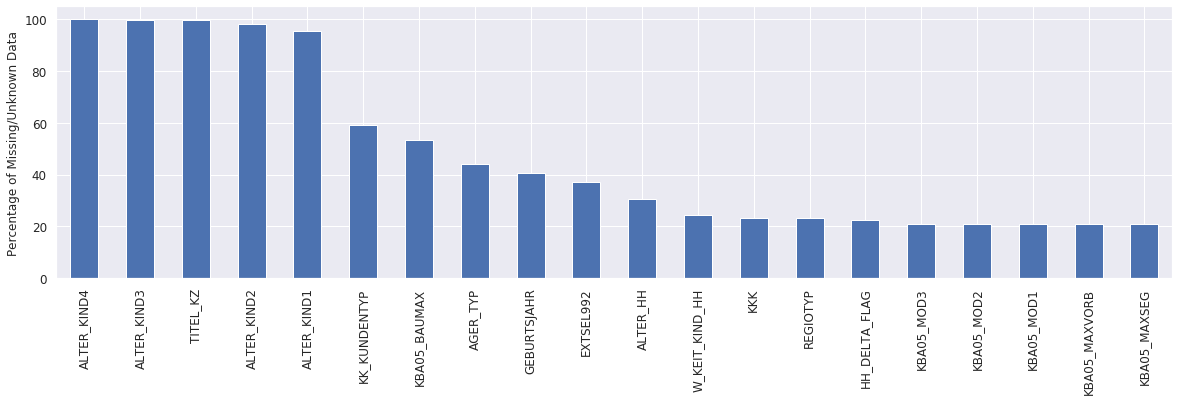

In [213]:
plot_miss_val(mailout_train, top_n=20)

In [214]:
mailout_train = mailout_train.dropna(thresh=10)
mailout_train.shape
#mailout_train['ALTER_KIND4'].fillna(0.0, inplace=True)
#mailout_train['ALTER_KIND3'].fillna(0.0, inplace=True)
#mailout_train['ALTER_KIND2'].fillna(0.0, inplace=True)
#mailout_train['ALTER_KIND1'].fillna(0.0, inplace=True)
#mailout_test['ALTER_KIND4'].fillna(0.0, inplace=True)
#mailout_test['ALTER_KIND3'].fillna(0.0, inplace=True)
#mailout_test['ALTER_KIND2'].fillna(0.0, inplace=True)
#mailout_test['ALTER_KIND1'].fillna(0.0, inplace=True)

(42962, 367)

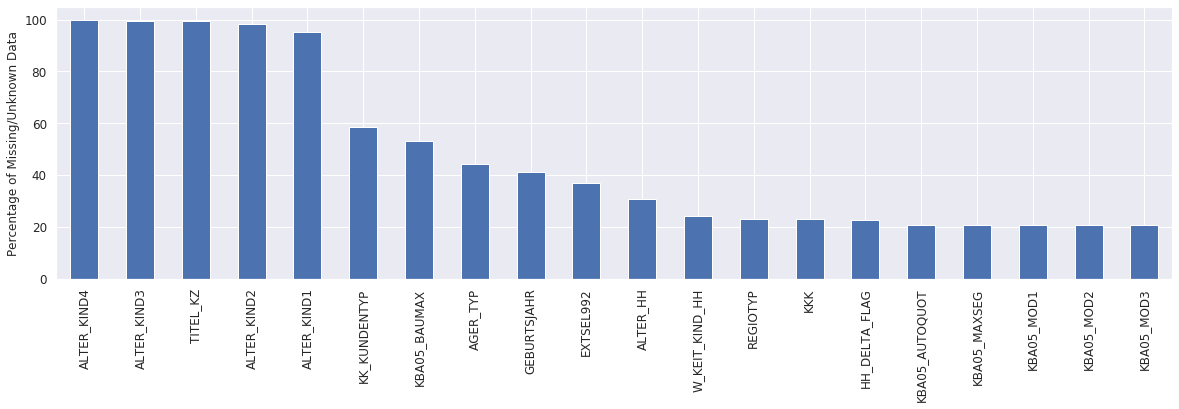

In [215]:
plot_miss_val(mailout_test, top_n=20)

In [216]:
#Drop columns with outlier number of misjsing columns
mailout_train_cols_drop = (mailout_train.isnull().sum()/len(mailout_train)).sort_values(ascending=False).where(lambda x: x > .25).dropna().index.tolist()
mailout_test_cols_drop = (mailout_test.isnull().sum()/len(mailout_test)).sort_values(ascending=False).where(lambda x: x > .4
                                                                                                           ).dropna().index.tolist()
print (mailout_train_cols_drop)
print (mailout_test_cols_drop)


['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 'GEBURTSJAHR', 'EXTSEL992', 'ALTER_HH']
['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 'GEBURTSJAHR']


In [217]:
drop_feat =[]
cols_drop = list(set(mailout_train_cols_drop) | set(mailout_test_cols_drop) | set(drop_feat) )
len(cols_drop)


11

In [218]:
print ('-------train dataset-------------')
mailout_train = drop_col(mailout_train, cols_drop)
print ('-------test dataset-------------')
mailout_test = drop_col(mailout_test, cols_drop)

-------train dataset-------------
dataset shape before dropping (42962, 367)
dataset shape after dropping (42962, 356)
-------test dataset-------------
dataset shape before dropping (42833, 366)
dataset shape after dropping (42833, 355)


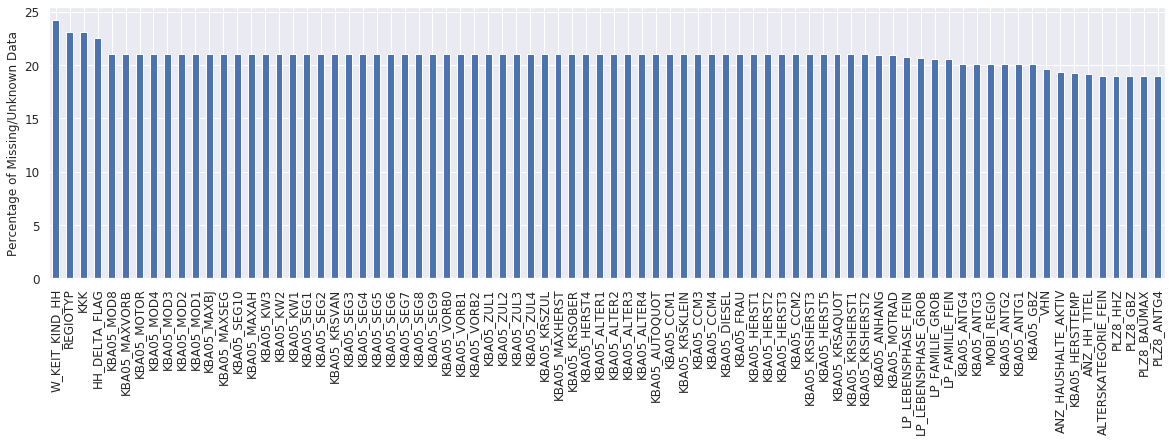

In [219]:
plot_miss_val(mailout_train, top_n=80)

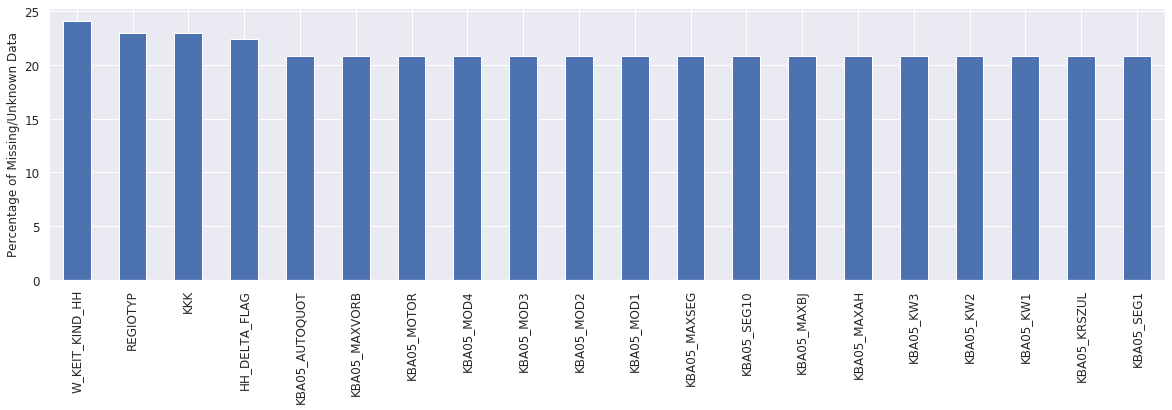

In [220]:
plot_miss_val(mailout_test, top_n=20)

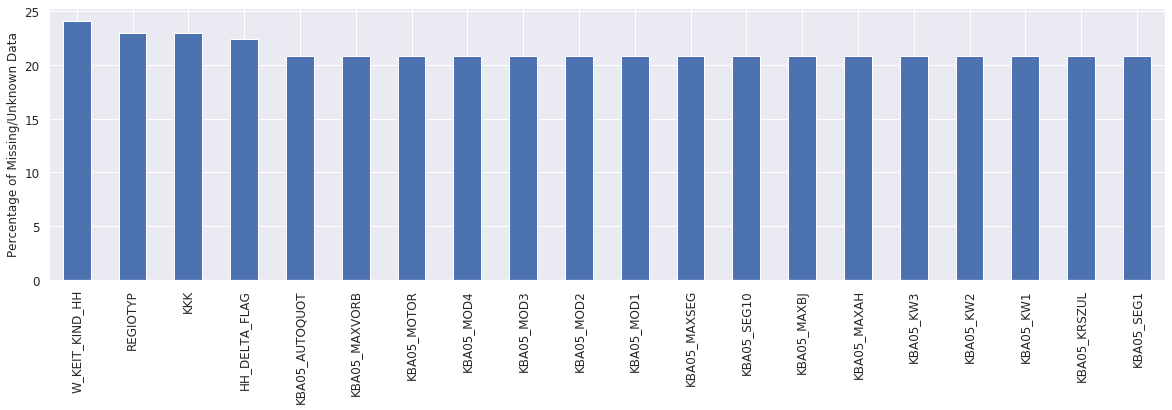

In [221]:
plot_miss_val(mailout_test, top_n=20)

### Preprocessing:

- Same function preprocessing function developed for handling object dtypes in unsupervised learning is used for following features in both training and test set.
- Same categorical variables were also used for encoding
- same steps of imputation, encoding, and scaling is carried out similar as in other notebook

In [222]:
mailout_train.dtypes.value_counts()
mailout_train.select_dtypes(include=["object"]).columns.values




array(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype=object)

In [223]:
mailout_train_copy = mailout_train.copy()
mailout_train_copy.drop(columns='RESPONSE', inplace = True)
mailout_test_copy = mailout_test.copy()

In [224]:

mailout_train_p = preprocessing(mailout_train_copy)
mailout_test_p = preprocessing(mailout_test_copy )

In [225]:
cols = mailout_train_copy.select_dtypes(include=["int"]).columns.values.tolist()
#print (cols)

cols = [
 'CAMEO_INTL_2015_STANDARD',
 'CAMEO_INTL_2015_LEBENSPHASE',
 #'CAMEO_DEUG_2015',   
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'D19_KONSUMTYP', 
 #'D19_LETZTER_KAUF_BRANCHE',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'HH_EINKOMMEN_SCORE',  
 'KOMBIALTER',
 'LP_FAMILIE_GROB',   
 'LP_STATUS_GROB',
 #'MOBI_REGIO',
 'NATIONALITAET_KZ',   
 'PRAEGENDE_JUGENDJAHRE_BEWEGUNG',
 'PRAEGENDE_JUGENDJAHRE_DEKADE',
 'SHOPPER_TYP',
 #'WOHNLAGE',    
 'ZABEOTYP']

Lot of important features have around 20% of missing values. Therefore imputation should play a major role in effectiveness of the learning model. In the following step, imputation (fill with zero), encoding, and scaling is carried out similar as in unsupervised learning. After this step we have 444 features.

In [226]:
%%time
scaler, mailout_train_df_imputed_enc_scaled = preprocess_pipeline(mailout_train_p, cols)
mailout_train_df_imputed_enc_scaled.shape

CPU times: user 4.79 s, sys: 1.3 s, total: 6.09 s
Wall time: 6.11 s


(42962, 471)

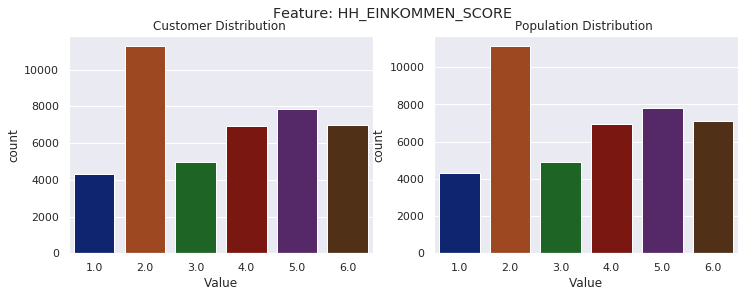

In [227]:
#model = pickle.load(open("model_kmeans_8.pkl", "rb"))
#pca_n = pickle.load(open("pca_280.pkl", "rb"))
#pca_n
#train_pca = pca_n.transform(mailout_train_df_imputed_enc_scaled) 
#train_pca.shape
#predict_clusters_train = model.predict(train_pca)
#series_azdias = pd.Series(predict_clusters_train)
plot_compare_feat('HH_EINKOMMEN_SCORE', mailout_train_p , mailout_test_p)

In [228]:
scaler, mailout_test_df_imputed_enc_scaled = preprocess_pipeline(mailout_test_p, cols)
mailout_test_df_imputed_enc_scaled.shape

(42833, 471)

In [229]:
#DEBUG: can make it a function
feat_train = mailout_train_df_imputed_enc_scaled.columns.values.tolist()
feat_test = mailout_test_df_imputed_enc_scaled.columns.values.tolist()
feat_not_described = np.setdiff1d(feat_train, feat_test)
feat_not_described
#azdias_df_imputed_enc_scaled.shape


array([], dtype='<U35')

### Supervised Learning

The different classifiers are used like
1) GBM: Gradient Boosting Classifier
2) LGBM: Light Gradient Boosting Machine
3) XGBoost  

In [230]:
y = mailout_train.RESPONSE
X_train, X_val, y_train, y_val = train_test_split(mailout_train_df_imputed_enc_scaled, y, stratify=y, test_size=0.2,random_state=2)

GBM performs the best without optimization. However, on hypertuning the parameters xgboost was found to have a better performance.

In [ ]:
def optimizeClassifier(clf, param_grid):
    classifier = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=6, verbose=0)
    classifier.fit(X_train, y_train)

    return classifier


parameters = {
    'learning_rate': [.1],
    'max_depth': [4],
    'n_estimators': [ 50, 100],
    'min_samples_split': [.6], #[.6, .7],
    }

clf_gbm = GradientBoostingClassifier(learning_rate=.1, n_estimators=100)
clf_xgb = xgb.XGBClassifier(learning_rate=.1, eval_metric='auc',n_estimators=100)
clf_lgb = lgb.LGBMClassifier(learning_rate=0.1, metric='auc',  n_estimators=100)
clf = [clf_gbm, clf_xgb, clf_lgb]
score_mean = [0,0,0]
score_std = [0,0,0]

for i in [0,1,2]:
    result = optimizeClassifier(clf[i], parameters)
    score_mean[i] = np.mean(result.cv_results_['mean_test_score'])
    score_std[i] = np.mean(result.cv_results_['std_test_score'])

In [193]:
print ('Validation Score (gbm, xgb, lgb)', score_mean)
print ('Validation Score deviation (gbm, xgb, lgb)', score_std)
print ('Training Score (gbm, xgb, lgb)', score_train_mean)
print ('Training Score deviation (gbm, xgb, lgb)', score_train_std)

Validation Score (gbm, xgb, lgb) [0.775787642835845, 0.7642202971036532, 0.7545566451473882]
Validation Score deviation (gbm, xgb, lgb) [0.015117077541897107, 0.014984238277671723, 0.01843921665950296]


Here, we see GBM has better validation score at cost of longer execution time. However, gbm was prone to overfitting. I.e. it showed better score on training set, but on test set the ROC-AUC score was low as seen during Kaggle submission. Futhermore, due to parallel processing in xgboost, training is much faster than gbm. This scales when during hypertuning 100s of parameter settings need to be tried. The XGBoost is also robust in handling missing data. It delivered better scores even on using fill missing values with 0 or -1.

In [206]:
#score = result.cv_results_["mean_test_score"]
#score_std = result.cv_results_["std_test_score"]
def show_score(feat, train_scores, test_scores, feat_name):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(train_scores_mean, train_scores_std)
    print(test_scores_mean, test_scores_std)
    plt.title("Train and Validation Scores")
    plt.fill_between(feat , train_scores_mean - train_scores_std,train_scores_mean + train_scores_std)
    plt.fill_between(feat , test_scores_mean - test_scores_std, test_scores_mean + test_scores_std)
    plt.xlabel(feat_name)
    plt.ylabel('ROC-AUC Score')
    plt.show()

[0.88948129 0.93985638 0.95721362 0.96443064 0.97021891 0.97551355] [0.00316447 0.00180183 0.00272997 0.00338971 0.00329134 0.00373964]
[0.75862085 0.76314633 0.75966342 0.7520659  0.74465974 0.73374969] [0.01137161 0.01332771 0.01286678 0.01406549 0.01172605 0.00944531]


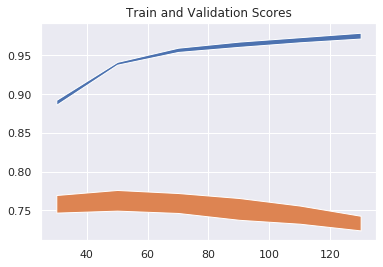

In [197]:
num_estimators= [30, 50, 70, 90, 110, 130]
train_scores, test_scores = validation_curve(clf_xgb,mailout_train_df_imputed_enc_scaled, y, 
                                             param_name='n_estimators', param_range = num_estimators, 
                                             scoring = 'roc_auc', cv=3, n_jobs = 6)


[0.88948129 0.93985638 0.95721362 0.96443064 0.97021891 0.97551355] [0.00316447 0.00180183 0.00272997 0.00338971 0.00329134 0.00373964]
[0.75862085 0.76314633 0.75966342 0.7520659  0.74465974 0.73374969] [0.01137161 0.01332771 0.01286678 0.01406549 0.01172605 0.00944531]


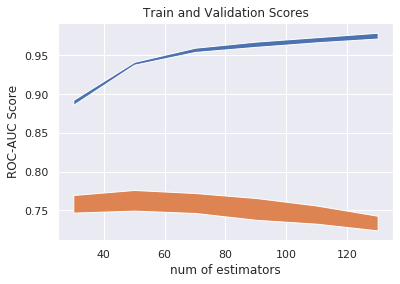

In [207]:

show_score(num_estimators, train_scores, test_scores, 'num of estimators')

[0.79803488 0.86386314 0.94146909 0.95894524 0.96787655] [0.01073988 0.00470234 0.00206515 0.00254926 0.0033272 ]
[0.75675226 0.7604566  0.76282474 0.76180738 0.75220838] [0.02405639 0.01647914 0.01371968 0.01268754 0.01394578]


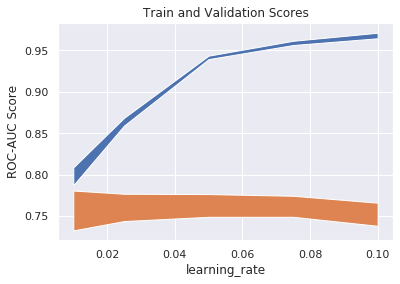

In [233]:
learning_rate = [.01, .025, .05, .075, .1]
train_scores, test_scores = validation_curve(clf_xgb,mailout_train_df_imputed_enc_scaled, y, 
                                            param_name='learning_rate', param_range = learning_rate, 
                                            scoring = 'roc_auc', cv=3, n_jobs = 6)
show_score(learning_rate, train_scores, test_scores, 'learning_rate' )

[0.96787655 0.96497936 0.96148347 0.95230421] [0.0033272  0.00279571 0.00261641 0.00323986]
[0.75220838 0.75287554 0.75013385 0.75675222] [0.01394578 0.01502162 0.01487664 0.01144018]


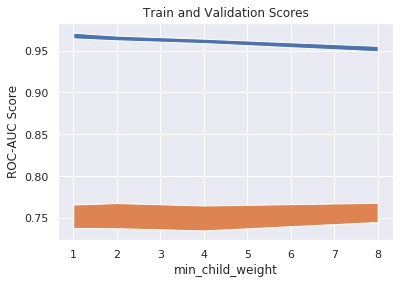

In [243]:
min_child_weight = [1, 2, 4, 8]
train_scores, test_scores = validation_curve(clf_xgb,mailout_train_df_imputed_enc_scaled, y, 
                                            param_name='min_child_weight', param_range = min_child_weight, 
                                            scoring = 'roc_auc', cv=3, n_jobs = 6)
show_score(min_child_weight, train_scores, test_scores, 'min_child_weight' )

[0.96858569 0.96759478 0.96777254 0.96721996 0.96742245] [0.00321892 0.00333384 0.0033737  0.00343934 0.00380787]
[0.75192055 0.74697533 0.74722799 0.74801022 0.74807313] [0.01425539 0.0148279  0.0125928  0.00883215 0.0067645 ]


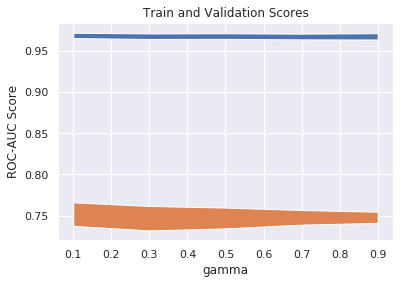

In [239]:
gamma = [.1, .3, .5, .7, .9]
train_scores, test_scores = validation_curve(clf_xgb,mailout_train_df_imputed_enc_scaled, y, 
                                            param_name='gamma', param_range = gamma, 
                                            scoring = 'roc_auc', cv=3, n_jobs = 6)
show_score(gamma, train_scores, test_scores, 'gamma')

[0.96787655 0.98726943 0.98924475 0.99042898 0.9910729 ] [0.0033272  0.0013086  0.00100017 0.00082398 0.00071649]
[0.75220838 0.70825875 0.7004157  0.69295684 0.68285521] [0.01394578 0.01257411 0.00801767 0.0087273  0.00843988]


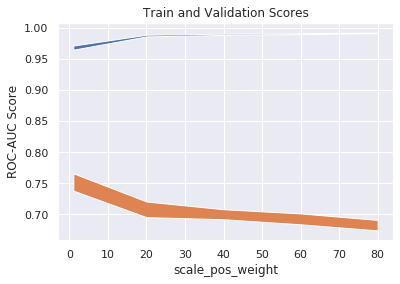

In [240]:

scale_pos_weight= [1, 20, 40, 60, 80]
train_scores, test_scores = validation_curve(clf_xgb, mailout_train_df_imputed_enc_scaled, y, 
                                            param_name='scale_pos_weight', param_range = scale_pos_weight, 
                                            scoring = 'roc_auc', cv=3, n_jobs = 6)
show_score(scale_pos_weight , train_scores, test_scores, 'scale_pos_weight' )

[0.97286554 0.9723802  0.97216351 0.97171358 0.97017228] [0.00239452 0.00164595 0.00342165 0.00230173 0.00359858]
[0.74199108 0.74664893 0.75113153 0.74984952 0.75719197] [0.00978943 0.01408554 0.01393351 0.01835731 0.01041957]


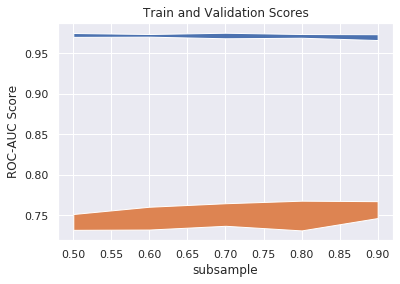

In [241]:

subsample = [.5, .6, .7, .8, .9]
train_scores, test_scores = validation_curve(clf_xgb, mailout_train_df_imputed_enc_scaled, y, 
                                            param_name='subsample', param_range = subsample, 
                                            scoring = 'roc_auc', cv=3, n_jobs = 6)
show_score(subsample , train_scores, test_scores, 'subsample' )

[0.96764901 0.9679635  0.96810126 0.96799314 0.96706897] [0.00231573 0.00326073 0.00242073 0.00304742 0.00239693]
[0.75742046 0.75198052 0.74808469 0.75493666 0.75582989] [0.00786763 0.0175561  0.01486595 0.01414498 0.01386875]


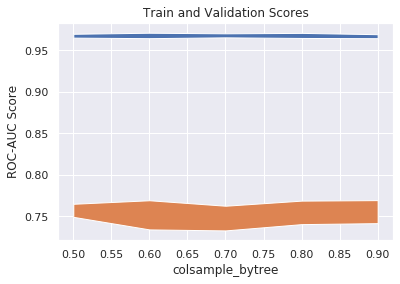

In [242]:
colsample_bytree = [.5, .6, .7, .8, .9]
train_scores, test_scores = validation_curve(clf_xgb, mailout_train_df_imputed_enc_scaled, y, 
                                            param_name='colsample_bytree', param_range = colsample_bytree, 
                                            scoring = 'roc_auc', cv=3, n_jobs = 6)
show_score(colsample_bytree , train_scores, test_scores, 'colsample_bytree' )

Individual optimization of parameters did not yield expected improvement as they seem to be correlated to each other. There, Bayes Search CV is used for intelligent exploration and tuning of parameters instead of brute force trying out of parameter combinations.

In [231]:
%%time
# Code Snippet from Kaggle: https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769
ITERATIONS = 200
  

SEED = 42
bayes_cv_tuner_xg = BayesSearchCV(estimator = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc'),
                    search_spaces = {
                        'learning_rate': (0.01, .2, 'log-uniform'),
                        'max_depth': (2, 5),
                        'min_child_weight': (2, 8),
                        #'gamma': (0.1, 1.0, 'uniform'),
                        'subsample': [0.7, .8, .9, 1.0],
                        'colsample_bytree': (0.5, 1.0, 'uniform'),
                        #'reg_alpha': (1e-9, 1.0, 'log-uniform'),
                        'n_estimators': (40, 110),
                        #'max_delta_step': (1, 10),
                        'colsample_bylevel': (0.1, 1.0, 'uniform'),
                        'scale_pos_weight': [1]
                        
                    },
                    scoring = 'roc_auc',
                    cv = StratifiedKFold(
                    n_splits=3,
                    shuffle=True,
                    ),
    n_iter = ITERATIONS,   
    refit = True,
    random_state = np.random.RandomState(50)
    )

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_xg.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_xg.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_xg.best_score_, 4),
        bayes_cv_tuner_xg.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner_xg.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

    
result_xg = bayes_cv_tuner_xg.fit(mailout_train_df_imputed_enc_scaled, y, callback=status_print)

Model #1
Best ROC-AUC: 0.7722
Best params: OrderedDict([('colsample_bylevel', 0.8748906002504084), ('colsample_bytree', 0.7256080813960445), ('learning_rate', 0.044788667562127515), ('max_depth', 5), ('min_child_weight', 2), ('n_estimators', 70), ('scale_pos_weight', 1), ('subsample', 0.8)])

Model #2
Best ROC-AUC: 0.7722
Best params: OrderedDict([('colsample_bylevel', 0.8748906002504084), ('colsample_bytree', 0.7256080813960445), ('learning_rate', 0.044788667562127515), ('max_depth', 5), ('min_child_weight', 2), ('n_estimators', 70), ('scale_pos_weight', 1), ('subsample', 0.8)])

Model #3
Best ROC-AUC: 0.7722
Best params: OrderedDict([('colsample_bylevel', 0.8748906002504084), ('colsample_bytree', 0.7256080813960445), ('learning_rate', 0.044788667562127515), ('max_depth', 5), ('min_child_weight', 2), ('n_estimators', 70), ('scale_pos_weight', 1), ('subsample', 0.8)])

Model #4
Best ROC-AUC: 0.7722
Best params: OrderedDict([('colsample_bylevel', 0.8748906002504084), ('colsample_bytree'

Model #31
Best ROC-AUC: 0.7726
Best params: OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 0.5), ('learning_rate', 0.08567004713461564), ('max_depth', 5), ('min_child_weight', 8), ('n_estimators', 59), ('scale_pos_weight', 1), ('subsample', 0.7)])

Model #32
Best ROC-AUC: 0.7726
Best params: OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 0.5), ('learning_rate', 0.08567004713461564), ('max_depth', 5), ('min_child_weight', 8), ('n_estimators', 59), ('scale_pos_weight', 1), ('subsample', 0.7)])

Model #33
Best ROC-AUC: 0.7726
Best params: OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 0.5), ('learning_rate', 0.08567004713461564), ('max_depth', 5), ('min_child_weight', 8), ('n_estimators', 59), ('scale_pos_weight', 1), ('subsample', 0.7)])

Model #34
Best ROC-AUC: 0.7726
Best params: OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 0.5), ('learning_rate', 0.08567004713461564), ('max_depth', 5), ('min_child_weight', 8), ('n_estimator

Model #63
Best ROC-AUC: 0.7726
Best params: OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 0.5), ('learning_rate', 0.08567004713461564), ('max_depth', 5), ('min_child_weight', 8), ('n_estimators', 59), ('scale_pos_weight', 1), ('subsample', 0.7)])

Model #64
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #65
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #66
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators',

Model #95
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #96
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #97
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #98
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 

Model #127
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #128
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #129
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #130
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimator

Model #159
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #160
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #161
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #162
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimator

Model #191
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #192
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #193
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimators', 40), ('scale_pos_weight', 1), ('subsample', 1.0)])

Model #194
Best ROC-AUC: 0.7737
Best params: OrderedDict([('colsample_bylevel', 0.7105358876479955), ('colsample_bytree', 0.5), ('learning_rate', 0.2), ('max_depth', 2), ('min_child_weight', 2), ('n_estimator

In [234]:
%%time
bayes_xgb = result_xg.best_estimator_
clf = bayes_xgb
clf.fit(X_train, y_train)

CPU times: user 8.75 s, sys: 163 ms, total: 8.91 s
Wall time: 1.42 s


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7105358876479955, colsample_bynode=1,
              colsample_bytree=0.5, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [235]:
preds = clf.predict_proba(X_train)
score_train = roc_auc_score(y_train,preds[:,1])
preds = clf.predict_proba(X_val)
score_val = roc_auc_score(y_val,preds[:,1])
print ('Training Score (xgb)', score_train)
print ('Validation Score (xgb)', score_val)

Training Score (xgb) 0.8133897562870867
Validation Score (xgb) 0.7584602199590496


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [236]:
preds = clf.predict_proba(mailout_test_df_imputed_enc_scaled)
kaggle_sub = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=preds[:,1])
#kaggle_sub = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=preds)
kaggle_sub.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_sub.to_csv('kaggle_sub.csv')

In [237]:
feature_importance_values= np.zeros((len(clf.feature_importances_)))
feature_importance_values += clf.feature_importances_
feature_importances = pd.DataFrame({'feature': mailout_test_df_imputed_enc_scaled.columns, 'importance': feature_importance_values})
drop_feat = feature_importances[feature_importances.importance!=0].sort_values(by='importance', ascending=False).feature.tolist()

drop_feat.sort()
#print ((drop_feat))
feature_importances[feature_importances.importance!=0].sort_values(by='importance', ascending=False).head(50)

,feature,importance
57,D19_SOZIALES,0.072725
46,D19_KONSUMTYP_MAX,0.048061
2,ANZ_HAUSHALTE_AKTIV,0.046974
365,D19_KONSUMTYP_9.0,0.036943
39,D19_GESAMT_DATUM,0.035318
162,KBA13_ALTERHALTER_30,0.033175
301,RT_SCHNAEPPCHEN,0.033094
130,KBA05_KW2,0.032680
238,KBA13_KW_30,0.031014
229,KBA13_KRSHERST_FORD_OPEL,0.030454


In [238]:
imp_feat_s = feature_importances[feature_importances.importance!=0].sort_values(by='importance', ascending=False).feature.tolist()
set(imp_feat) & set(imp_feat_s[:50])

{'ALTERSKATEGORIE_FEIN', 'D19_SOZIALES', 'EINGEZOGENAM_HH_JAHR', 'KBA05_MOTOR'}

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = mailout_train_df_imputed_enc_scaled.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Remove the columns
#app = app.drop(columns = to_drop)